In [12]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

df = pd.read_csv("../../data/raw/sell-in.csv", sep="\t")
df = df.groupby(by=["periodo","product_id"]).agg({"tn":"sum"}).reset_index()
df = df[~df["periodo"].isin([201910, 201911, 201912])]
df_test = df[df["periodo"] == 201910].copy()
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df_pivot = df.pivot(index="product_id", columns="periodo", values="tn").fillna(0)
print(f"Shape de la matriz: {df_pivot.shape}")  # (800 productos x 36 meses)

gc.collect()

Shape de la matriz: (1190, 33)


33721

In [13]:
scalers = {}  # Guardamos los scalers para invertir luego
scaled_data = np.zeros_like(df_pivot.values)

for i, (producto, fila) in enumerate(df_pivot.iterrows()):
    scaler = StandardScaler()
    scaled_data[i] = scaler.fit_transform(fila.values.reshape(-1, 1)).flatten()
    scalers[producto] = scaler  # Almacenar scaler para este producto

In [14]:
X, y, productos = [], [], []

for i_producto, producto in enumerate(df_pivot.index):
    serie = scaled_data[i_producto]
    for i in range(12, len(serie) - 2):  # Asegurar que t+2 exista
        X.append(serie[i-12:i].reshape(-1, 1))  # Shape: (12, 1)
        y.append(serie[i+1])  # t+2 (i+1 es el offset desde el fin de la ventana)
        productos.append(producto)  # Identificador del producto

X = np.array(X)  # Shape: (n_muestras, 12, 1)
y = np.array(y).reshape(-1, 1)  # Shape: (n_muestras, 1)

In [15]:
from sklearn.model_selection import train_test_split

productos_unicos = df_pivot.index.unique()
productos_train, productos_test = train_test_split(productos_unicos, test_size=0.2, random_state=42)

# Máscaras para filtrar
train_mask = [p in productos_train for p in productos]
test_mask = [p in productos_test for p in productos]

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', input_shape=(12, 1), return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Salida para t+2
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/100


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.8169 - mae: 0.6737 - val_loss: 0.8100 - val_mae: 0.6209 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.7267 - mae: 0.5928 - val_loss: 0.7686 - val_mae: 0.6047 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.7321 - mae: 0.5926 - val_loss: 0.7596 - val_mae: 0.6071 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.7281 - mae: 0.5871 - val_loss: 0.7452 - val_mae: 0.6179 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.6892 - mae: 0.5812 - val_loss: 0.7259 - val_mae: 0.6020 - learning_rate: 0.0010
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.6976 - mae: 0.5856 - val_loss: 0.7240 - val_mae: 0.5917 - learning_rate: 0.0010
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.6946 - mae: 0.5754 - val_loss: 0.7120 - val_mae: 0.5930 - learning_rate: 0.0010
Epoch 8/100
71/71 

In [19]:
def predecir_t2(product_id, ultimos_12_meses):
    """
    product_id: ID del producto (ej: 'P001').
    ultimos_12_meses: Array con las tn de los últimos 12 meses (en orden cronológico).
    """
    scaler = scalers[product_id]
    ultimos_12_scaled = scaler.transform(np.array(ultimos_12_meses).reshape(-1, 1))
    X_new = ultimos_12_scaled.reshape(1, 12, 1)
    y_pred_scaled = model.predict(X_new)
    return (y_pred_scaled * scaler.scale_) + scaler.mean_

# Ejemplo: Predecir para el primer producto en el test set
producto_ejemplo = productos_test[0]
ultimos_12_ejemplo = df_pivot.loc[producto_ejemplo].iloc[-12:].values
prediccion = predecir_t2(producto_ejemplo, ultimos_12_ejemplo)
print(f"Predicción t+2 para {producto_ejemplo}: {prediccion[0][0]:.2f} tn")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
Predicción t+2 para 20393: 4.84 tn


In [20]:
productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")
productos_ok = df["product_id"].unique()
def predecir_todos(productos_a_predecir):
    predicciones = {}
    for producto in productos_a_predecir:
        ultimos_12 = df_pivot.loc[producto].iloc[-12:].values
        prediccion = predecir_t2(producto, ultimos_12)
        predicciones[producto] = prediccion[0][0]
    return predicciones
predicciones = predecir_todos(productos_ok)
predicciones_df = pd.DataFrame.from_dict(predicciones, orient='index', columns=['prediccion_t2'])
predicciones_df.index.name = 'product_id'
predicciones_df.reset_index(inplace=True)
predicciones_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

,product_id,prediccion_t2
0,20001,1421.917207
1,20002,1020.026562
2,20003,901.195003
3,20004,595.694037
4,20005,549.072752
...,...,...
1185,20962,0.308025
1186,20975,0.289348
1187,20995,0.267772
1188,21087,0.014744


In [21]:
predicciones_df.columns = ["product_id", "tn"]
predicciones_df.to_csv("../entregable/outputs/prediccion_lstm_v1.csv", sep = ",", index = False)

In [14]:
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
df = df.groupby(by=["periodo","product_id"]).agg({"tn":"sum"}).reset_index()
df_test = df[df["periodo"] == 201912].copy()

In [17]:
#df_final = df_test.merge(predicciones_df, on="product_id", how="left")
df_final.to_csv("LSTM_2_test.csv", index=False, sep=",")

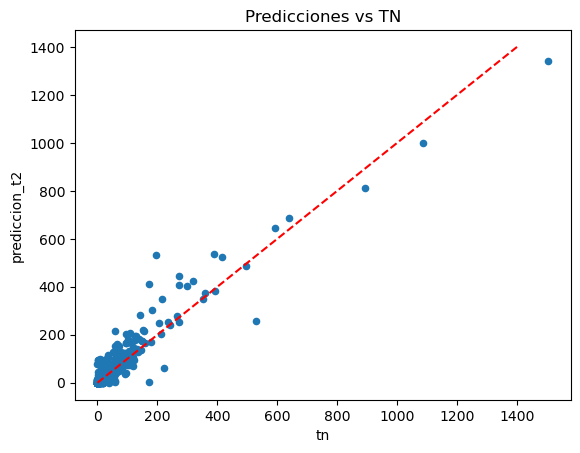

In [ ]:
import matplotlib.pyplot as plt
df_final["pred_085"] = df_final["tn"] * 0.85
df_final.plot(kind="scatter", x="tn", y="prediccion_t2", title="Predicciones vs TN")
plt.plot([0, 1400], [0, 1400], 'r--')
plt.show()

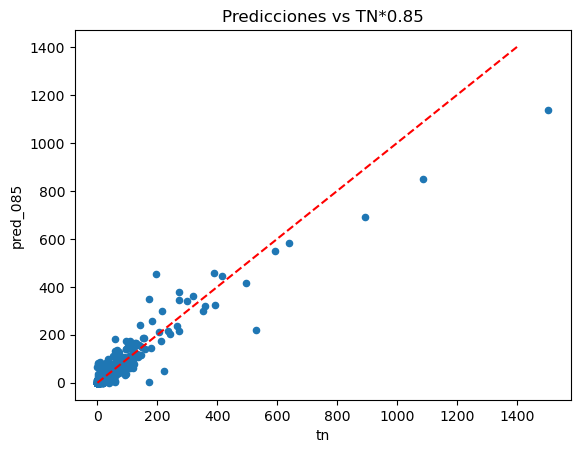

In [69]:
import matplotlib.pyplot as plt
df_final["pred_085"] = df_final["prediccion_t2"] * 0.85
df_final.plot(kind="scatter", x="tn", y="pred_085", title="Predicciones vs TN*0.85")
plt.plot([0, 1400], [0, 1400], 'r--')
plt.show()

In [58]:
print(df_final["prediccion_t2"].sum(),"|",df_final["tn"].sum())

30561.81642706056 | 26217.067280000003


In [66]:
1/(df_final["prediccion_t2"].sum()/df_final["tn"].sum())

0.8578373390393919

In [59]:
df_final["prediccion_t2"].sum()*0.98

29950.58009851935

In [60]:
numerador = (df_final["tn"]- df_final["prediccion_t2"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error_inicial = (numerador / denominador)
porcentaje_error_inicial

0.38328836173655084

In [61]:
numerador = (df_final["tn"]- df_final["prediccion_t2"]*0.95).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

0.3621192610584073

In [67]:
numerador = (df_final["tn"]- df_final["prediccion_t2"]*0.85).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

0.34410504256341534

In [ ]:
numerador = (df_final["tn"]- df_final["prediccion_t2"]*0.95).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

In [22]:
df_final

,periodo,product_id,tn,prediccion_t2
0,201912,20001,1504.68856,1339.309341
1,201912,20002,1087.30855,999.335004
2,201912,20003,892.50129,813.822117
3,201912,20004,637.90002,687.820608
4,201912,20005,593.24443,645.766224
...,...,...,...,...
922,201912,21265,0.05007,0.031273
923,201912,21266,0.05121,0.034404
924,201912,21267,0.01569,0.031634
925,201912,21271,0.00298,0.011370


In [ ]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

C:\Users\carre\AppData\Local\Temp\ipykernel_13880\4091618781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')


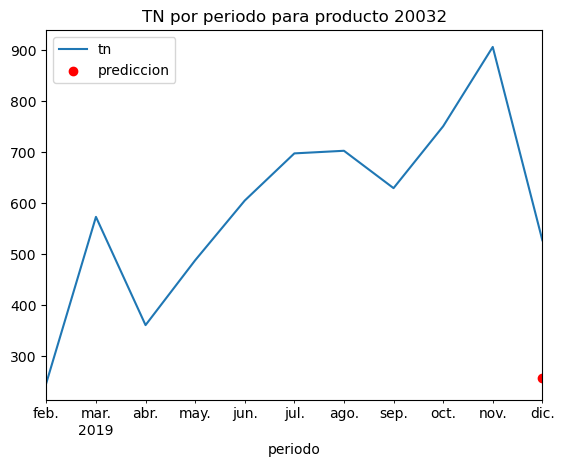

In [72]:


prod = 20032
prod_s = sellin[sellin["product_id"] == prod]
prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
#prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

import matplotlib.pyplot as plt

ax = plt.gca()
prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
#plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
prediccion = df_final[df_final["product_id"] == prod]["prediccion_t2"].values[0]
plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
plt.legend()
plt.show()

In [49]:
df_final["error"] = (df_final["tn"] - df_final["prediccion_t2"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)

In [50]:
df_final

,periodo,product_id,tn,prediccion_t2,error,error_relativo
7,201912,20008,195.36854,532.575173,337.206633,1.726003
31,201912,20032,527.79811,257.856035,269.942075,0.511449
11,201912,20012,173.13004,413.121853,239.991813,1.386194
13,201912,20014,272.02812,444.827483,172.799363,0.635226
117,201912,20127,170.32792,4.584798,165.743122,0.973083
...,...,...,...,...,...,...
926,201912,21276,0.00892,0.009059,0.000139,0.015627
598,201912,20728,14.31612,NaN,NaN,NaN
627,201912,20770,3.18500,NaN,NaN,NaN
646,201912,20792,3.80934,NaN,NaN,NaN
